STEP 1: Look at the Big  Picture 
(I have understood the problem and know the goal of the model)

STEP 2: GET THE DATA

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH =  "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path): #make the path if it doesn't exist
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
import pandas as pd
#Loading the data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)


#Fetch and Load the data
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
#inspecting the  "ocean_proximity" attribute
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
#Describing the numerical fields 
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


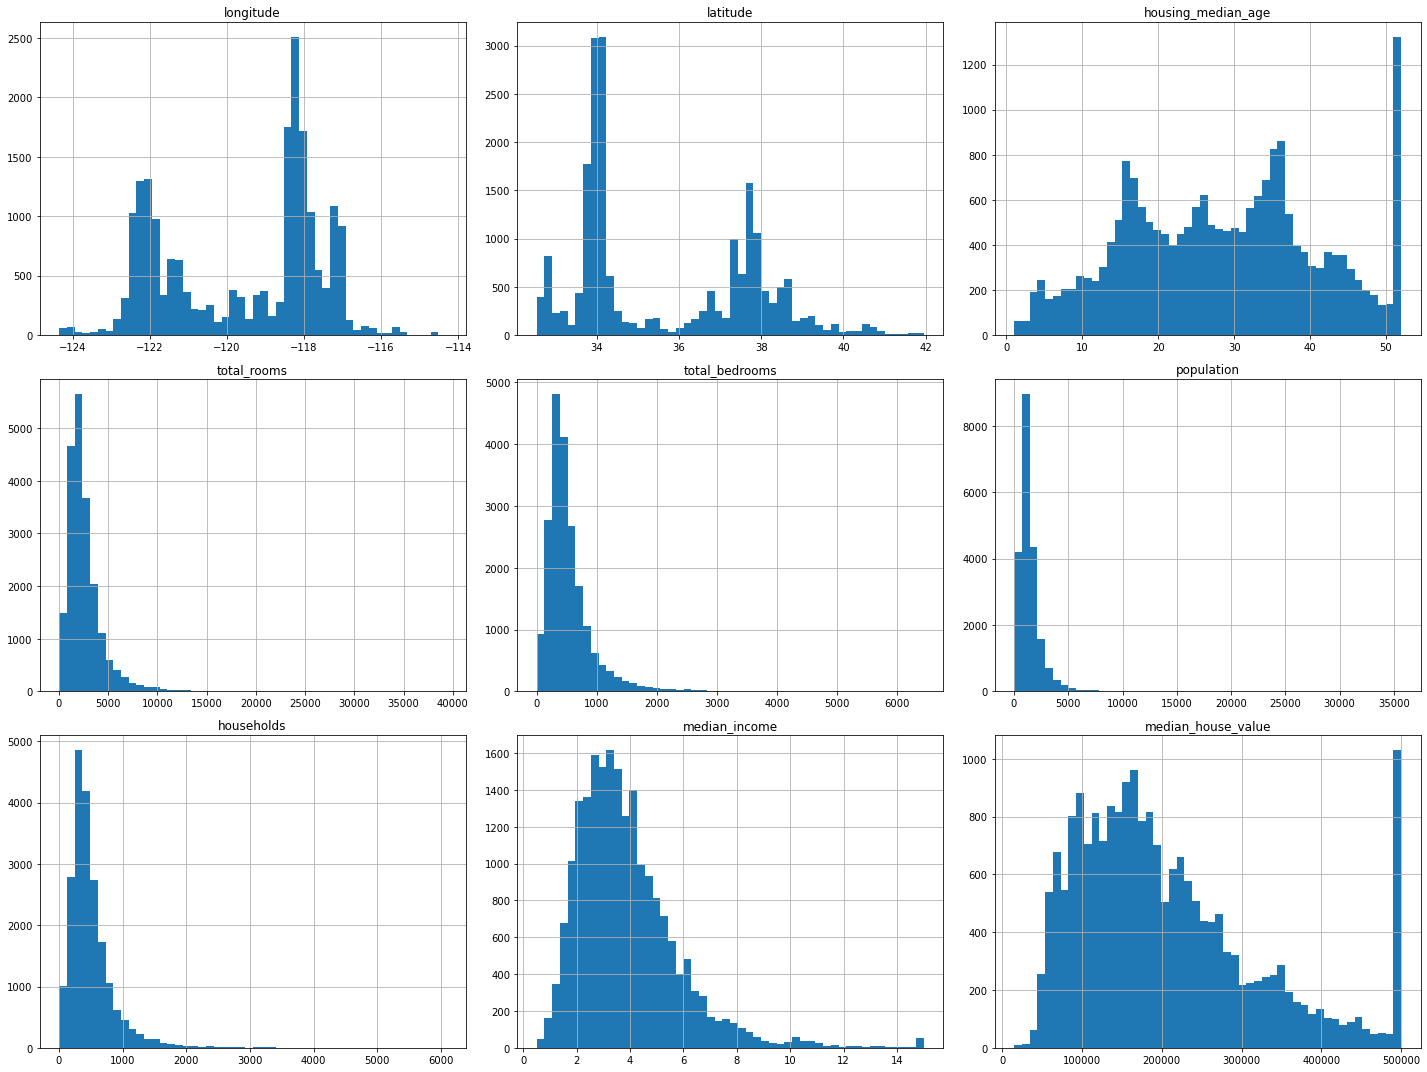

In [6]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project_practice"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


#To gain quick insight on the data, we'll use some histograms
import matplotlib.pyplot as plt
%matplotlib inline
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots", fig_extension="jpg")
plt.show()


Create a Test Set

In [7]:
#We'll fix the tail heaviness, unit problem, hard capping and scaling problems later.
#We need to create a test set first before looking at the data too much
#We also want to keep the test set constant per run to avoid the mistakenly exposing the test set to the training model. Well use a hash function

import numpy as np
np.random.seed(42)
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    #keep only the last byte of the hash, and put the instance in the test set if this value <= 51 (~20% of 256 possible values) or our chosen test ratio.
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio    
    
def split_train_set_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[-in_test_set], data.loc[in_test_set]

#Generate a suitable ID using longitude and latitude
housing_with_id = housing.copy() #make a copy of the housing dataframe
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
    

In [8]:
#split the data into train set and test set using a random split
train_set_rand, test_set_rand = split_train_set_by_id(housing_with_id, 0.2, "id")
test_set_rand.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,id
count,4373.000000,4373.000000,4373.000000,4373.000000,4325.000000,4373.000000,4373.000000,4373.000000,4373.000000,4373.000000
mean,-119.711685,35.783169,27.697462,2674.638235,538.448324,1424.038418,500.897553,3.964195,210401.988338,-119675.902172
std,2.041053,2.209536,12.138070,2176.718349,411.781289,1068.917156,374.259657,1.906693,114201.150923,2039.015719
min,-124.300000,32.560000,1.000000,2.000000,1.000000,6.000000,1.000000,0.499900,22500.000000,-124258.200000
25%,-121.920000,33.940000,18.000000,1487.000000,299.000000,792.000000,282.000000,2.606500,122900.000000,-121881.980000
50%,-118.970000,34.400000,28.000000,2191.000000,441.000000,1178.000000,417.000000,3.640600,187300.000000,-118932.360000
75%,-117.950000,37.790000,36.000000,3221.000000,647.000000,1754.000000,607.000000,4.928600,267600.000000,-117916.330000
max,-114.630000,41.860000,52.000000,37937.000000,5471.000000,16122.000000,5189.000000,15.000100,500001.000000,-114597.240000


In [9]:
train_set_rand.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,id
count,16267.000000,16267.000000,16267.000000,16267.000000,16108.000000,16267.000000,16267.000000,16267.000000,16267.000000,16267.000000
mean,-119.531536,35.591186,28.892728,2625.312412,537.715421,1425.863404,499.174648,3.845529,205902.512203,-119495.945053
std,1.991663,2.113958,12.691610,2182.878515,423.939077,1148.976727,384.480832,1.897243,115699.564560,1989.706730
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,-124309.460000
25%,-121.710000,33.930000,18.000000,1438.500000,295.000000,786.000000,279.000000,2.553900,118800.000000,-121673.170000
50%,-118.450000,34.240000,29.000000,2112.000000,432.000000,1164.000000,408.000000,3.512500,177400.000000,-118415.700000
75%,-118.030000,37.690000,37.000000,3124.500000,647.000000,1718.000000,603.500000,4.703250,264000.000000,-117995.920000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,-114275.810000


In [10]:
print(len(train_set_rand), 'train +', len(test_set_rand), 'test')

16267 train + 4373 test


Stratified Splitting of the Dataset for Data with clear stratas (Layers)

Saving figure median_income


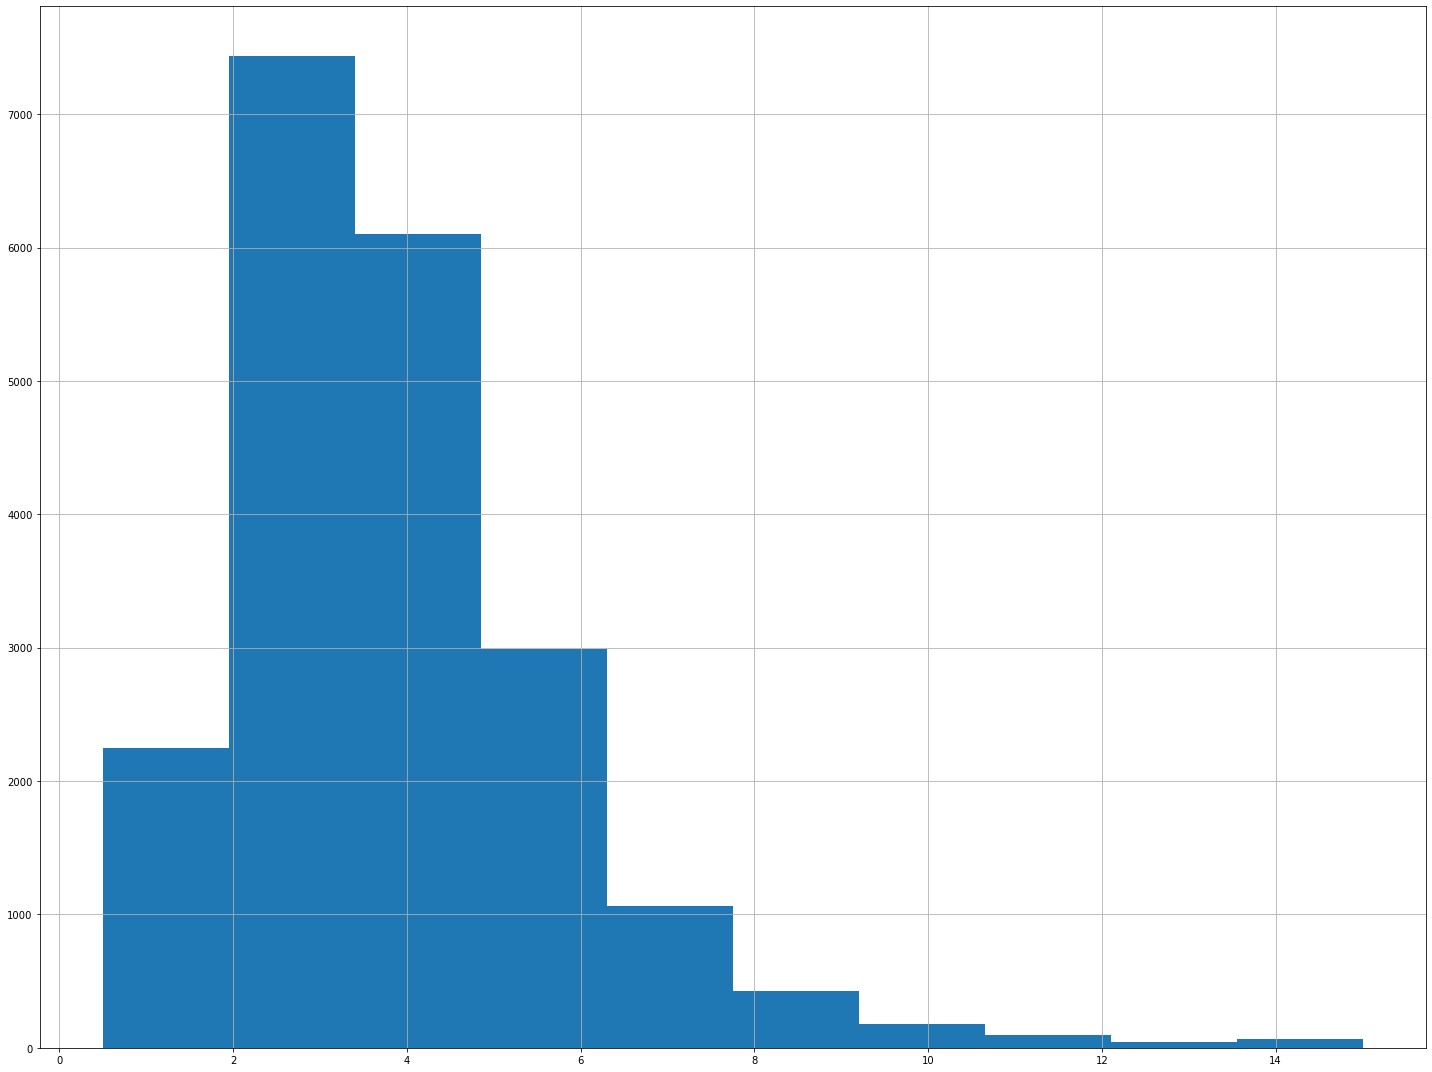

In [11]:
#I'll look for these stratas first by visualising the median income
housing["median_income"].hist(bins = 10, figsize= (20,15))
save_fig("median_income")




In [12]:
#Then I will split the data based on what i can see (divide the income to 5 categories)
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) # divide by 1.5 to limit the number of categories
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True) #Values above 5 are labelled as 5

housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

Saving figure income categories


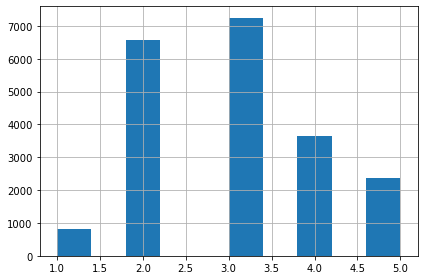

In [13]:
housing["income_cat"].hist()
save_fig("income categories")

In [14]:
#Stratified Sampling
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
#Drop off the income_cat attribute form the train and test sets
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

STEP 3: DISCOVER AND VISUALIZE THE DATA

(our Dataset is small so there isn't a need for an exploration set)

Saving figure First_Viz_Plot


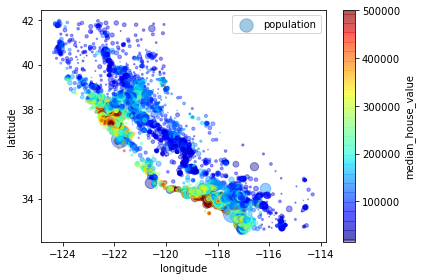

In [16]:
#visualising graphical data by plotting Longitude against Latitude

#we set s(radius of each circle), c(color of each circle), and cmap (color map) -> Jet ranges from blue to red
#This makes the plot show more information 
#The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.4,
             s=housing["population"]/100, label="population",
             c="median_house_value", cmap = plt.get_cmap("jet"), colorbar = True,
             sharex=False)
save_fig("First_Viz_Plot")

We can see that housing prices is related to the location and population density. Clustering Algorithms could provide more features

In [17]:
#A more sophisticated plot
#Download an image of california from using already created directories from above
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(IMAGES_PATH, filename))

('.\\images\\end_to_end_project_practice\\california.png',
 <http.client.HTTPMessage at 0x18d6bd681c8>)

C:\ProgramData\Anaconda3\envs\myMLenv\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


Saving figure california_housing_prices_advanced_plt


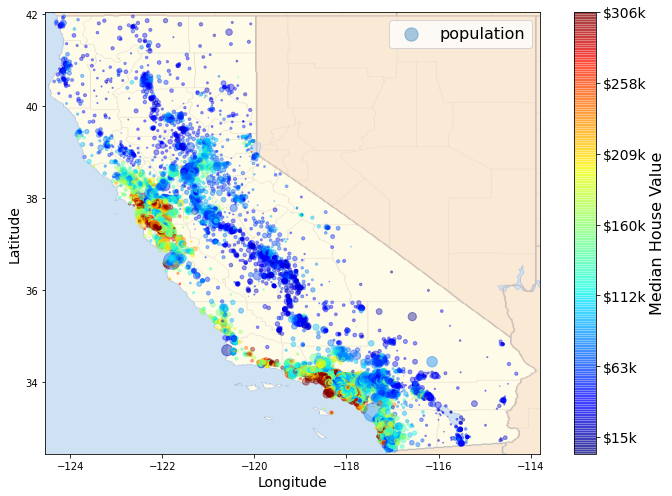

In [18]:
#We create a more complex plot and use the image lib as well
import matplotlib.image as mpimg
#Read the image
california_img=mpimg.imread(PROJECT_ROOT_DIR + "/images/" + CHAPTER_ID +"/california.png")

#Our initial scatter plot but remove color bar because we would creat one
ax = housing.plot(kind = "scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing["population"]/100, label="population",
                  c="median_house_value", cmap = plt.get_cmap("jet"), 
                  colorbar = False, alpha=0.4
                  )
#Also plot the image
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)



#For the Colour bar
prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label("Median House Value", fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_advanced_plt")
plt.show()




We look for correlation to get useful features (Linear correlation)

In [19]:
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False) #To get correlation with our label/target

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

median income is the most promising attribute to predict median house value, we'll get it's scatter plot

Saving figure income_vs_house_value_scatterplot


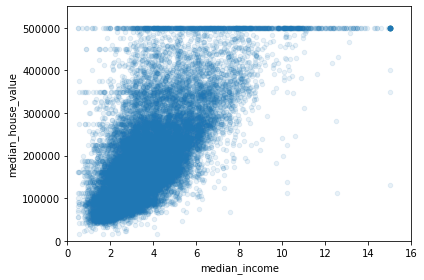

In [20]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0,16,0,550000])
save_fig("income_vs_house_value_scatterplot")

Above, we notice that the correlation is strong but there are also some price caps at specific prices. We can also fix the tail heaviness of the distribution by computing logarithms.

We'll create other attributes that we think matters, this is an iterative process. I might come back here

In [21]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]


In [22]:
housing.corr()["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

So bedrooms per room is a much better attribute (better correlation) than total bedrooms or total rooms

STEP 4: Prep the Data for ML Algorithms

Rather than doing the transformations separately, we would create a pipeline for everything later, for now we shall describe all the transformations taking place.

In [23]:
#Lets revert the training set by copying it  from the strat_train_set
#and separate the predictors and labels

housing =  strat_train_set.drop("median_house_value", axis = 1) # drop the lables for the training set
housing_labels = strat_train_set["median_house_value"].copy()

#There are some missing  features which we will fill with the median
try:
    from sklearn.impute import SimpleImputer #Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
    
imputer = SimpleImputer(strategy="median")


#we remove the text attribute because median is only calculated on numerical attributes
housing_num = housing.select_dtypes(include=[np.number]) # or the code below
#housing_num = housing.drop("ocean_proximity", axis =1)



# we fit the Imputer Instance to our data
imputer.fit(housing_num)

#view the values
imputer.statistics_


array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [24]:
housing_num.median().values #To verify that it worked

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [25]:
#We Transform the training set
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [26]:
#to view some of the incomplete rows
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
housing_tr.loc[sample_incomplete_rows.index.values] # quite verbose

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [27]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


Handling Text and Categorical Attributes

In [28]:
#We would use Transformers 

#Let us create a categorical input feature
housing_cat = housing[['ocean_proximity']] #note the double square brackets to return a DF
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [29]:
#We'll use a OneHotEncoder for the categories of the ocean proximity.

try:
    from sklearn.preprocessing import OrdinalEncoder #just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder #Scikit-Learn < 0.20
    
    
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Creation of Custom Transformers

(Scikit-Learn relies on duck typing, we'll create a transformer class and implement fit(), transform() and fit_transform() and adding TransformerMixin and BaseEstimator as base classes)

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

#We get the colum location of the following attributes using a list comprehension
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

#Previous hard coded implementation
#rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6  #The column location of these attributes in the DataFrame


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):  #no args or *kargs since we are using BaseEstimator as a base class
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self #nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

#Code for using a FunctionTransformer rather than creating your own class

""" from sklearn.preprocessing import FunctionTransformer

def add_extra_features (X, add_bedrooms_per_room=True):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]  
        

attr_adder =FunctionTransformer(add_extra_features, validate=False,
                                kw_args={"add_bedrooms_per_room": False}) #Validate is set to False because of non-float values in the data
housing_extra_attribs = attr_adder.fit_transform(housing.values)  """ 




' from sklearn.preprocessing import FunctionTransformer\n\ndef add_extra_features (X, add_bedrooms_per_room=True):\n        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]\n        population_per_household = X[:, population_ix] / X[:, household_ix]\n        if self.add_bedrooms_per_room:\n            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]\n            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]\n        \n        else:\n            return np.c_[X, rooms_per_household, population_per_household]  \n        \n\nattr_adder =FunctionTransformer(add_extra_features, validate=False,\n                                kw_args={"add_bedrooms_per_room": False}) #Validate is set to False because of non-float values in the data\nhousing_extra_attribs = attr_adder.fit_transform(housing.values)  '

In [31]:
#we convert it to a dataframe and add the new Column names
housing_extra_attribs = pd.DataFrame(housing_extra_attribs,
                                     columns= list(housing.columns)+["rooms_per_household", "population_per_household"],
                                     index= housing.index)

housing_extra_attribs.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847


Feature Scaling (Transformation)
(to make the scale of the data similar so that algorithms can perform well)

We'll use Standardization

Transformation Pipeline

In [32]:
#You can use a custom DataFrameSelector transformer and a FeatureUnion to combine different 
#pipelines for different types of data or attributes but

#We'll use a ColumnTransformer to combine the pipelines so no need for a DataFrameSelector
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer #Scikit-Learn <0.20

#import Pipelines and the standard scaler   
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
    
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])


full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(),cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)
    


In [33]:
#Lets peep the shape
housing_prepared.shape

(16512, 16)

STEP 5: SELECT AND TRAIN A MODEL

In [34]:
#1. Linear Regression

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
#we would have to run the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)


print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [36]:
#We would compare this result to the actual value (The labels)
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [37]:
#Let us use a better method of evaluating the model
#We'll use the mean_squared_error function

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse



68628.19819848922

In [38]:
#we'll also calculate the mean absolute error so we import the necessary files

from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

Our Linear Model is clearing Underfitting (the training data) so we will use a more powerful model

In [39]:
#2. Decision Tree  Regressor

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [40]:
#Lets evaluate this model on the training set
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

This error is unrealistic. It is probably overfitting the training data. We'll use cross validation to check for this.

We'll use some Cross validation Techniques and Try some other models


In [41]:
from sklearn.model_selection import cross_val_score

#This splits the training data and test set into smaller training and validation set
#We are performing a K-fold cross validation, training and evaluating the model K times and
#and picking a different fold for evaluation every time and training on the other K-1 times
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores) #-ve because the scoring was done using a utility function not an error func

#we'll display the scores using this 
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [68238.05196774 66817.04578495 70753.16954743 69884.28682243
 70568.69371449 74169.72026563 71656.23162198 70466.17619771
 76555.53603628 69481.84893535]
Mean: 70859.07608940084
Standard deviation 2652.359918121003


In [42]:
#Doing the cross validation for the linear regression model

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation 2731.674001798347


So the Decision Tree overfits and performs worse than the linear regression model

We'll try a Random Forest

In [43]:
from sklearn.ensemble import RandomForestRegressor

#We are using a random forest of 10 decision trees
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [44]:
#predicting with the model and calculating the rmse score
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [45]:
#Running a cross validation on the model

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring ="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation 2298.353351147122


This is more promising but it is still being overfitted (The score on training set is lower than on the validation sets)

We would regularise it later (constrain the model by tweaking the hyper parameters)

Lets try a Support Vector Machine (SVM) Regressor (SVR)

In [46]:
from  sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

An SVR is considerably worse, we'll stick with a Random Forest

STEP 6: Finetune your model

We make a list of the promising models and fine tune them

In [47]:
#Using Grid Search rather than fiddling with the hyperparameters
#(values and combination) yourself 

#We would state the hyperparameters we want to test and what values to try out
#we would use it for the random forest

from sklearn.model_selection import GridSearchCV

param_grid = [
    #try 12 (3x4) combinations of hyperparameters
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    #then try 6 (2x3) combinations with bootstrap set as False
    {"bootstrap" : [False], "n_estimators" : [3, 10], "max_features" : [2, 3, 4]}
] 

forest_reg = RandomForestRegressor(random_state=42)
#train across 5 folds,  that's a total of (12+6)x5 = 90 rounds of training

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
  

In [48]:
#We can print out the best parameters thus
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [49]:
#To see the scores of all the hyperparameter combination
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.061642,0.002787,0.002797,4.002896e-04,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053749e+09,1.519609e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.207632,0.016422,0.008179,3.997806e-04,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094381e+09,1.327046e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.592401,0.041396,0.023345,1.473087e-03,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626879e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.095355,0.006762,0.002593,4.886368e-04,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716852e+09,1.631421e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.309373,0.011191,0.007978,2.156865e-06,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781611e+09,1.268562e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,0.950897,0.057135,0.024316,2.501727e-03,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537877e+09,1.214603e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.128257,0.008430,0.002793,3.989458e-04,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441447e+09,1.893141e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.418890,0.018382,0.008178,3.979684e-04,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704640e+09,1.471542e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.299494,0.133668,0.023345,1.350982e-03,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514668e+09,1.285063e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.152803,0.000970,0.002395,7.962597e-04,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348851e+09,1.241864e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


In [50]:
#We print out the best estimators 
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

This is the best, we can specify the refit=True  (This is the default) in the GridSearchCV constructor 
to make it retrain the whole dataset using this combination

In [51]:
#Trying a Randomized Search

#This gives you more control on the number of combination especially when 
# the search space is large
#The benefits is that you cancontrol your computing budget and
# an run more specialized searches

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#we would have 10 iterations but test 1-200 estimators and 1-8 features at each 
#iteration between 5 fold trainings
param_distribs = {
    "n_estimators" : randint(low=1, high=200),
    "max_features" : randint(low=1, high=8)
}

forest_reg = RandomForestRegressor(random_state=42) 
rnd_search = RandomizedSearchCV(forest_reg, param_distributions= param_distribs,
                                n_iter = 10, cv = 5, scoring = "neg_mean_squared_error",
                                random_state=42)

rnd_search.fit(housing_prepared, housing_labels)



RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [52]:
#printing the results
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


Ensemble Methods

We would combine the models together (ensemble them)to get a  better model

In [54]:
#First we need to see the feature importances from the grid search
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [55]:
#Let's display the importance between scores beside the corresponding attribute
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]